
Condition directories: ['/net/bbi/vol1/data/SGE/Shawn/iPSC_SGE/POLG/POLG_X16_W748S_reads']
Looking for pDNA files in: /net/bbi/vol1/data/SGE/Shawn/iPSC_SGE/POLG

Processing W748S...
Found 5 libraries total
Library names: ['POLG_W748S_X16_iPSC_d14_r5_S20', 'POLG_W748S_X16_iPSC_d14_r2_S17', 'POLG_W748S_X16_iPSC_d14_r3_S18', 'POLG_W748S_X16_iPSC_d14_r4_S19', 'POLG_X16_pDNA_L1']
Total variants before filtering: 78163
Total variants after filtering: 438
Using pDNA library: POLG_X16_pDNA_L1
Using pDNA column: POLG_X16_pDNA_L1_freq
Variants passing pDNA frequency threshold: 438
Found 4 score columns for averaging: ['POLG_W748S_X16_iPSC_d14_r5_S20_pDNA_score', 'POLG_W748S_X16_iPSC_d14_r2_S17_pDNA_score', 'POLG_W748S_X16_iPSC_d14_r3_S18_pDNA_score', 'POLG_W748S_X16_iPSC_d14_r4_S19_pDNA_score']
Calculated average score column: W748S_average_score

Normalization statistics for W748S_average_score:
  Synonymous median: -0.317
  Synonymous std: 0.642
  Synonymous n: 89
  Z-score thresholds:
    z 

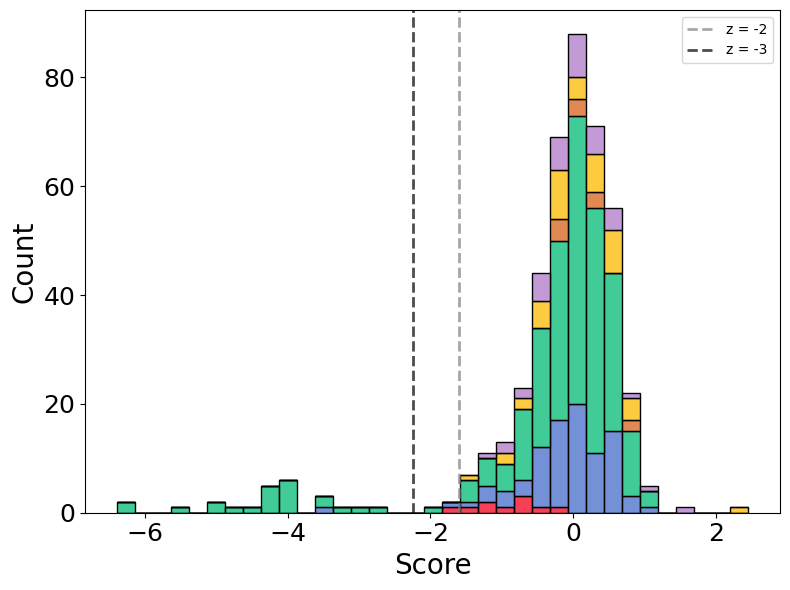


Condition directories: ['/net/bbi/vol1/data/SGE/Shawn/iPSC_SGE/POLG/POLG_X16_null_reads']
Looking for pDNA files in: /net/bbi/vol1/data/SGE/Shawn/iPSC_SGE/POLG

Processing null...
Found 3 libraries total
Library names: ['POLG_WT_X16_iPSC_d14_r4_S16', 'POLG_WT_X16_iPSC_d14_r3_S15', 'POLG_X16_pDNA_L1']
Total variants before filtering: 71400
Total variants after filtering: 438
Using pDNA library: POLG_X16_pDNA_L1
Using pDNA column: POLG_X16_pDNA_L1_freq
Variants passing pDNA frequency threshold: 438
Found 2 score columns for averaging: ['POLG_WT_X16_iPSC_d14_r4_S16_pDNA_score', 'POLG_WT_X16_iPSC_d14_r3_S15_pDNA_score']
Calculated average score column: null_average_score

Normalization statistics for null_average_score:
  Synonymous median: 0.318
  Synonymous std: 0.686
  Synonymous n: 89
  Z-score thresholds:
    z = -2: -1.054
    z = -3: -1.740
Saved results to: /net/bbi/vol1/data/SGE/Shawn/iPSC_SGE/POLG/POLG_null_scores.csv
Final variant count: 438
Saved plot to: /net/bbi/vol1/data/SG

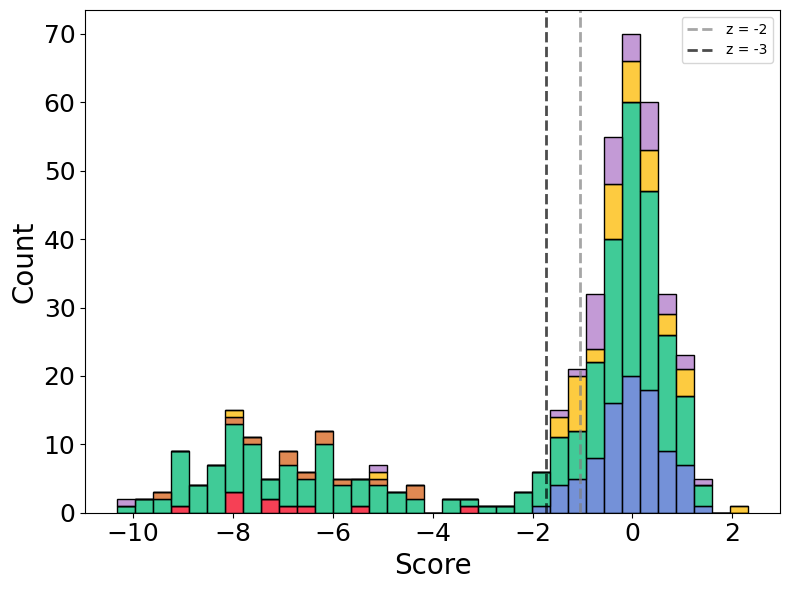

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from collections import Counter
from functools import reduce
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuration
GATE_FREQ = 1e-6
MIN_PDNA_FREQ = 0.00000767
WT_SEQ = "CTGCTAAGACCCATTTCCTTCCCCTGCACCCCACCAGGCACCCCGACTATGATGAGGAAGGCCTCTATGGGGCCATCCTGCCCCAAGTGGTGACTGCCGGCACCATCACTCGCCGGGCTGTGGAGCCCACATGGCTCACCGCCAGCAATGCCCGGGTATGTGACCTCTGTACCTCTGGCCCCTGC"

# Color palette
COLORS = {
    "Nonsense": "#F3001C",
    "Canon_splice": "#d6621a",
    "intron": "#af79c9",
    "missense": "#00BA74",
    "Splice region": "#fdba00",
    "Synonymous": "#456CCC",
}

# Translation table
CODON_TABLE = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'X', 'TAG':'X', 'TGC':'C', 'TGT':'C', 'TGA':'X', 'TGG':'W',
}

def translate(seq):
    """Translate DNA sequence to protein."""
    protein = ""
    realseq = seq[38:155]
    if len(realseq) % 3 == 0:
        for i in range(0, len(realseq), 3):
            codon = realseq[i:i + 3]
            protein += CODON_TABLE.get(codon, '')
    return protein

def load_fastq_files(directories):
    """Load all assembled fastq files from multiple directories."""
    barcodes = {}
    
    if isinstance(directories, str):
        directories = [directories]
    
    for directory in directories:
        fastq_files = glob(os.path.join(directory, '*.assembled.fastq'))
        
        for filename in fastq_files:
            with open(filename, 'r') as f:
                lines = f.readlines()
                seqs = [line.rstrip() for line in lines[1::4]]
            barcodes[os.path.basename(filename).split('.')[0]] = seqs
    
    return barcodes

def calculate_frequencies(barcodes):
    """Calculate frequencies for each library."""
    barcodes_freq = {}
    barcodes_unique_count = {}
    
    for lib, seqs in barcodes.items():
        counts = Counter(seqs)
        total = len(seqs)
        barcodes_unique_count[lib] = counts
        barcodes_freq[lib] = {seq: count/total for seq, count in counts.items()}
    
    return barcodes_freq, barcodes_unique_count

def correct_constant_regions(seq, wt_seq):
    """Correct constant regions in sequences."""
    if len(seq) != len(wt_seq):
        return None
    const_start = wt_seq[:22]
    const_end = wt_seq[-17:]
    return const_start + seq[22:-17] + const_end

def build_merged_dataframe(barcodes_freq, barcodes_unique_count, wt_seq, gate_freq):
    """Build and merge dataframes from sequencing data."""
    dataframes = []
    
    for lib, freq_data in barcodes_freq.items():
        count_data = barcodes_unique_count[lib]
        corrected_mapping = {}
        
        for variant, frequency in freq_data.items():
            corrected_seq = correct_constant_regions(variant, wt_seq)
            if corrected_seq is None:
                continue
            
            raw_count = count_data.get(variant, 0)
            
            if corrected_seq not in corrected_mapping:
                corrected_mapping[corrected_seq] = {'freq': 0, 'count': 0}
            
            corrected_mapping[corrected_seq]['freq'] += frequency
            corrected_mapping[corrected_seq]['count'] += raw_count
        
        filtered_data = [
            {'seq': seq, f'{lib}_freq': data['freq'], f'{lib}_count': data['count']}
            for seq, data in corrected_mapping.items()
            if data['freq'] >= gate_freq
        ]
        
        dataframes.append(pd.DataFrame(filtered_data))
    
    if dataframes:
        master_df = reduce(lambda left, right: pd.merge(left, right, on='seq', how='outer'), dataframes)
        master_df = master_df.fillna(0)
    else:
        master_df = pd.DataFrame(columns=['seq'])
    
    return master_df

def classify_consequence(seq, wt_seq, aa_wt):
    """Classify variant consequence."""
    translation = translate(seq)
    conseq = sum(1 for a, b in zip(translation, aa_wt) if a != b)
    
    if seq == wt_seq:
        return 'WT'
    elif conseq == 0:
        if seq[0:22] != wt_seq[0:22] or seq[168:] != wt_seq[168:]:
            return 'Junk'
        elif seq[22:29] != wt_seq[22:29] or seq[163:168] != wt_seq[163:168]:
            return 'intron'
        elif seq[29:35] != wt_seq[29:35] or seq[37:40] != wt_seq[37:40] or \
             seq[152:155] != wt_seq[152:155] or seq[157:163] != wt_seq[157:163]:
            return 'Splice region'
        elif seq[35:37] != wt_seq[35:37] or seq[155:157] != wt_seq[155:157]:
            return 'Canon_splice'
        else:
            return 'Synonymous'
    elif conseq == 1:
        diff_pos = [i for i in range(len(translation)) if translation[i] != aa_wt[i]][0]
        if translation[diff_pos] == 'X':
            return 'Nonsense'
        elif seq[168:] != wt_seq[168:] or seq[0:22] != wt_seq[0:22]:
            return 'Junk'
        else:
            return 'missense'
    return 'multiple'

def filter_and_annotate(df, wt_seq):
    """Filter and annotate variants."""
    aa_wt = translate(wt_seq)
    
    # Annotate variant type
    df["type"] = df["seq"].apply(
        lambda s: 'WT' if s == wt_seq else 
                  'SNV' if sum(1 for a, b in zip(s, wt_seq) if a != b) == 1 else 
                  'multiple'
    )
    
    # Filter out multiple SNVs, indels, and sequences with N
    df = df[df["type"] != "multiple"]
    df = df[df["seq"].str.len() == len(wt_seq)]
    df = df[~df["seq"].str.contains('N')]
    
    # Classify consequences
    df["consequence"] = df["seq"].apply(lambda s: classify_consequence(s, wt_seq, aa_wt))
    df = df[df["consequence"] != "Junk"]
    df = df[df["consequence"] != "WT"]
    
    return df

def calculate_pDNA_scores(df, pdna_column):
    """Calculate pDNA scores for all frequency columns."""
    freq_cols = [col for col in df.columns if col.endswith('_freq') and col != pdna_column]
    
    for col in freq_cols:
        # Replace zeros with small pseudocount
        col_adjusted = df[col].replace(0, 0.00001)
        pdna_adjusted = df[pdna_column].replace(0, 0.00001)
        
        # Calculate score
        score_col = col.replace('_freq', '_pDNA_score')
        df[score_col] = np.log2(col_adjusted / pdna_adjusted)
    
    return df

def normalize_to_synonymous(df, avg_score_col):
    """Normalize average score to synonymous median and calculate z-scores."""
    # Get synonymous variants
    syn_scores = df[df['consequence'] == 'Synonymous'][avg_score_col]
    
    if len(syn_scores) == 0:
        print(f"Warning: No synonymous variants found for {avg_score_col}")
        return df
    
    # Calculate synonymous statistics
    syn_median = syn_scores.median()
    syn_std = syn_scores.std()
    
    print(f"\nNormalization statistics for {avg_score_col}:")
    print(f"  Synonymous median: {syn_median:.3f}")
    print(f"  Synonymous std: {syn_std:.3f}")
    print(f"  Synonymous n: {len(syn_scores)}")
    
    # Normalize to synonymous median (set median to 0)
    norm_col = f"{avg_score_col}_norm_syn"
    df[norm_col] = df[avg_score_col] - syn_median
    
    # Calculate z-scores relative to synonymous distribution
    zscore_col = f"{avg_score_col}_zscore"
    df[zscore_col] = (df[avg_score_col] - syn_median) / syn_std
    
    # Calculate z-score thresholds for later use in plotting
    z_minus2 = syn_median - 2 * syn_std
    z_minus3 = syn_median - 3 * syn_std
    
    print(f"  Z-score thresholds:")
    print(f"    z = -2: {z_minus2:.3f}")
    print(f"    z = -3: {z_minus3:.3f}")
    
    return df, z_minus2, z_minus3

def plot_histogram(df, score_col, consequence_col, output_filename, z_thresholds=None):
    """Plot and save histogram of scores by consequence."""
    plot_data = df[[score_col, consequence_col]].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(plot_data) == 0:
        print(f"No valid data to plot for {score_col}")
        return
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.histplot(
        data=plot_data,
        x=score_col,
        hue=consequence_col,
        ax=ax,
        bins=35,
        legend=True,
        fill=True,
        palette=COLORS,
        edgecolor='black',
        linewidth=1,
        multiple="stack"
    )
    
    # Add z-score threshold lines if provided
    if z_thresholds is not None:
        z_minus2, z_minus3 = z_thresholds
        ax.axvline(x=z_minus2, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='z = -2')
        ax.axvline(x=z_minus3, color='black', linestyle='--', linewidth=2, alpha=0.7, label='z = -3')
        ax.legend()
    
    ax.set_xlabel('Score', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_facecolor('white')
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {output_filename}")
    plt.show()
    plt.close()

def process_condition(condition_dirs, base_dir, condition_name, pdna_lib_pattern):
    """Process all files for a given condition."""
    print(f"\nProcessing {condition_name}...")
    
    # Load condition data from subdirectories AND pDNA from main directory
    all_dirs = condition_dirs + [base_dir]
    barcodes = load_fastq_files(all_dirs)
    
    if not barcodes:
        print(f"No fastq files found")
        return None
    
    print(f"Found {len(barcodes)} libraries total")
    print(f"Library names: {list(barcodes.keys())}")
    
    # Calculate frequencies
    barcodes_freq, barcodes_unique_count = calculate_frequencies(barcodes)
    
    # Build merged dataframe
    df = build_merged_dataframe(barcodes_freq, barcodes_unique_count, WT_SEQ, GATE_FREQ)
    print(f"Total variants before filtering: {len(df)}")
    
    # Filter and annotate
    df = filter_and_annotate(df, WT_SEQ)
    print(f"Total variants after filtering: {len(df)}")
    
    # Find pDNA column - use the actual library name, not just pattern
    pdna_lib_names = [lib for lib in barcodes.keys() if pdna_lib_pattern in lib]
    
    if not pdna_lib_names:
        print(f"ERROR: No pDNA library found matching pattern '{pdna_lib_pattern}'")
        print(f"Available libraries: {list(barcodes.keys())}")
        return None
    
    pdna_lib_name = pdna_lib_names[0]
    pdna_col = f"{pdna_lib_name}_freq"
    
    if pdna_col not in df.columns:
        print(f"ERROR: pDNA column '{pdna_col}' not found in dataframe")
        return None
    
    print(f"Using pDNA library: {pdna_lib_name}")
    print(f"Using pDNA column: {pdna_col}")
    
    # Filter by minimum pDNA frequency
    df = df[df[pdna_col] >= MIN_PDNA_FREQ]
    print(f"Variants passing pDNA frequency threshold: {len(df)}")
    
    # Calculate scores
    df = calculate_pDNA_scores(df, pdna_col)
    
    # Find all score columns for this condition (excluding the pDNA library itself)
    # Get list of non-pDNA library names
    condition_lib_names = [lib for lib in barcodes.keys() if pdna_lib_pattern not in lib]
    
    score_columns = [f"{lib}_pDNA_score" for lib in condition_lib_names if f"{lib}_pDNA_score" in df.columns]
    
    print(f"Found {len(score_columns)} score columns for averaging: {score_columns}")
    
    if score_columns:
        # Calculate average score
        avg_col_name = f"{condition_name}_average_score"
        df[avg_col_name] = df[score_columns].mean(axis=1)
        print(f"Calculated average score column: {avg_col_name}")
        
        # Normalize to synonymous and calculate z-scores
        df, z_minus2, z_minus3 = normalize_to_synonymous(df, avg_col_name)
        z_thresholds = (z_minus2, z_minus3)
    else:
        print("WARNING: No score columns found to average")
        z_thresholds = None
    
    return df, z_thresholds

def main():
    """Main processing function."""
    base_dir = os.getcwd()
    
    # Define conditions to process
    conditions = {
        'W748S': {
            'pattern': 'POLG_X16_W748S*',
            'pdna_lib_pattern': 'pDNA',  # Pattern to identify pDNA columns
            'output_csv': 'POLG_W748S_scores.csv',
            'output_plot': 'POLG_W748S_histogram.png'
        },
        'null': {
            'pattern': 'POLG_X16_null*',
            'pdna_lib_pattern': 'pDNA',
            'output_csv': 'POLG_null_scores.csv',
            'output_plot': 'POLG_null_histogram.png'
        }
    }
    
    # Process each condition
    for condition_name, config in conditions.items():
        print(f"\n{'='*60}")
        
        # Find matching condition directories
        condition_dirs = glob(os.path.join(base_dir, config['pattern']))
        
        if not condition_dirs:
            print(f"No condition directories found matching pattern: {config['pattern']}")
            continue
        
        print(f"Condition directories: {condition_dirs}")
        print(f"Looking for pDNA files in: {base_dir}")
        
        result = process_condition(
            condition_dirs,
            base_dir,
            condition_name,
            config['pdna_lib_pattern']
        )
        
        if result is None:
            print(f"No data to save for {condition_name}")
            continue
        
        df, z_thresholds = result
        
        if df is not None and len(df) > 0:
            # Save to CSV
            output_csv = os.path.join(base_dir, config['output_csv'])
            df.to_csv(output_csv, index=False)
            print(f"Saved results to: {output_csv}")
            print(f"Final variant count: {len(df)}")
            
            # Plot histogram with normalized scores
            avg_score_col = f"{condition_name}_average_score_norm_syn"
            if avg_score_col in df.columns:
                output_plot = os.path.join(base_dir, config['output_plot'])
                plot_histogram(df, avg_score_col, 'consequence', output_plot, z_thresholds)
        else:
            print(f"No data to save for {condition_name}")

if __name__ == "__main__":
    main()